This notebook will compare HiChiP and HiChIRP datasets at a global level.

In [89]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import collections
import math
import scipy
import scipy.stats
import cPickle as pickle
import Queue
csv.register_dialect("textdialect", delimiter='\t')
HOME = "/home/raflynn/directionality"
! mkdir interm/nb3
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mkdir: cannot create directory `interm/nb3': File exists


## Collapsing all valid pairs to a 1D bedgraph

To ease metagene making

### Check that sorting is ok, and look at distance between PET ends and DHS's

In [ ]:
! mkdir interm/nb3/test_sorting
! head -n1000000 data/loops/v65_Med1_merge_allValidPairs | \
awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
> interm/nb3/test_sorting/v65_Med1_top1m.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/test_sorting/v65_Med1_top1m.bed > interm/nb3/test_sorting/v65_Med1_top1m_sorted1.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/test_sorting/v65_Med1_top1m.bed > interm/nb3/test_sorting/v65_Med1_top1m_sorted12.bed
! bedtools intersect -a interm/nb3/test_sorting/v65_Med1_top1m_sorted1.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/test_sorting/v65_Med1_top1m_sorted1_dhs.bed
! bedtools intersect -a interm/nb3/test_sorting/v65_Med1_top1m_sorted12.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/test_sorting/v65_Med1_top1m_sorted12_dhs.bed

# they are the same. that is because we don't use the -sorted flag for 
# bedtools intersect (the -b file is small so no need to sort)

# bedtools closest will require it though
! bedtools closest -a interm/nb3/test_sorting/v65_Med1_top1m_sorted1.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/test_sorting/v65_Med1_top1m_sorted1_closest_dhs.bed
! bedtools closest -a interm/nb3/test_sorting/v65_Med1_top1m_sorted12.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5+5000,$7,$9}' \
> interm/nb3/test_sorting/v65_Med1_top1m_sorted12_closest_dhs.bed

In [344]:
# let's see how far things are from DHS's -- take first 1M pairs, of which 500K are >20kb
# then graph how far the ends of a pair are from their closest DHS
nums = []
with open("interm/nb3/test_sorting/v65_Med1_top1m_sorted12_closest_dhs.bed", 'r') as ifile:
#ctr = 0
#with open("interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted_dhs20_closest.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
#        ctr += 1
#        if ctr == 1e7: break
        dist = int(row[3])-int(row[1])
        if row[-1] == '-':
            dist *= -1  # flip
        nums.append(dist)
nums = np.array(nums)

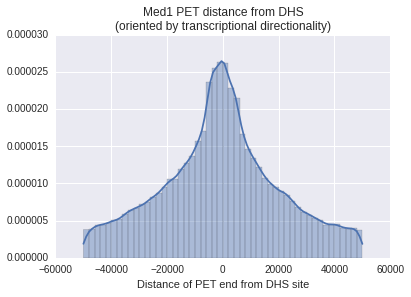

In [345]:
sns.distplot(nums[np.abs(nums) < 50000])
sns.plt.xlabel("Distance of PET end from DHS site")
sns.plt.title("Med1 PET distance from DHS\n(oriented by transcriptional directionality)")

In [156]:
len(nums[(nums>-5000) & (nums<0)])  # 94535
len(nums[(nums>0) & (nums<5000)])  # 88093  --> slight bias towards non-transcribed side
len(nums[(nums>-2500) & (nums<0)])  # 47165
len(nums[(nums>0) & (nums<2500)])  # 45592

567014

In [101]:
len(nums[(nums<5000) & (nums> -5000)])  # 182649 out of 1.04M are within 5kb
len(nums[(nums<10000) & (nums> -10000)])  # 302244 out of 1.04M are within 10kb
len(nums[(nums<20000) & (nums> -20000)])  # 468025 out of 1.04M are within 20kb
len(nums[(nums<50000) & (nums> -50000)])  # 719447 out of 1.04M are within 50kb
len(nums[(nums<100000) & (nums> -100000)])  # 889361 out of 1.04M are within 100kb

889361

let's see how far things are from DHS's -- take first 1M pairs, of which 500K are >20kb
then graph how far the ends of a pair are from their closest DHS

In [191]:
dhs_to_nums = collections.defaultdict(lambda: [])
#with open("interm/nb3/test_sorting/v65_Med1_top1m_sorted12_closest_dhs.bed", 'r') as ifile:
ctr = 0
with open("interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted_dhs20_closest.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        ctr += 1
        if ctr == 5e7: break
        dist = int(row[3])-int(row[1])
        if np.abs(dist) > 20000: continue  # only look at proximal PETs
        dhs_to_nums[row[-2]].append(dist)
        
dhs_to_direc = {}
with open("interm/nb1/160504_dhs_grodirec_sorted.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dhs_to_direc[row[3]] = float(row[-2]) 
        if row[-1] == '-': dhs_to_direc[row[3]] *= -1

In [203]:
dhs_to_info = collections.defaultdict(lambda: [])  # [loopratio, direc_ratio]
for dhs in dhs_to_nums:
    nums = np.array(dhs_to_nums[dhs])
    try:
        loop_ratio = np.log2(len(nums[(nums>0) & (nums<5000)])/float(len(nums[(nums<0) & (nums> -5000)])))
        if not np.isfinite(dhs_to_direc[dhs]): continue
        if not np.isfinite(loop_ratio): continue
        dhs_to_info[dhs] = [loop_ratio, dhs_to_direc[dhs]]
    except:
        pass
    
df = pd.DataFrame.from_dict(dhs_to_info, orient='index')
df = df[(np.abs(df[1])>1) & (np.abs(df[0])>1)]
df.head()

,0,1
chr10__80391727__80393727__80392675__DHSpeak_9299__5_Active_Promoter__183,-3.220048,5.652548
chr11__115873083__115875083__115874045__DHSpeak_18151__7_Active_Promoter__160,-4.989558,-2.073581
chr11__62418284__62420284__62419285__DHSpeak_14087__4_Poised_Enhancer__455,3.180938,5.271359
chr11__52152942__52154942__52153795__DHSpeak_13399__9_Strong_Enhancer__388,3.086464,1.215849
chr11__95867461__95869461__95868495__DHSpeak_16299__7_Active_Promoter__364,2.882123,1.422599


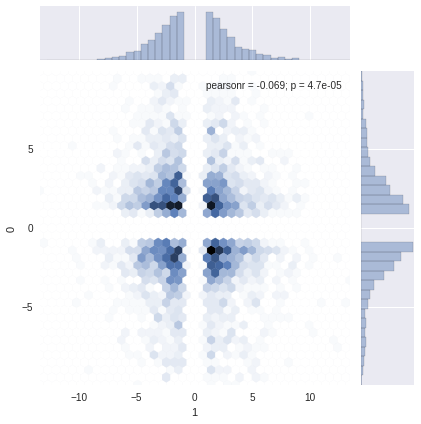

In [204]:
sns.jointplot(x=1, y=0, data=df, kind="hex")

In [205]:
print df[(df[0]>0) & (df[1]>0)].shape[0]
print df[(df[0]>0) & (df[1]<0)].shape[0]
print df[(df[0]<0) & (df[1]>0)].shape[0]
print df[(df[0]<0) & (df[1]<0)].shape[0]

777
971
903
865


Thus, there is a slight bias towards loop anchors being on the OPPOSITE side of a DHS from transcriptional machinery, although this effect does not correlate with strength of transcription.

In [108]:
! head -n1000000 data/loops/v65_cohesin_merge_allValidPairs | \
awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
> interm/nb3/test_sorting/v65_cohesin_top1m.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/test_sorting/v6d5_cohesin_top1m.bed > interm/nb3/test_sorting/v65_cohesin_top1m_sorted12.bed
! bedtools closest -a interm/nb3/test_sorting/v65_cohesin_top1m_sorted12.bed \
-b interm/nb1/160504_dhs_grodirec_sorted.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5+1000,$7,$9}' \
> interm/nb3/test_sorting/v65_cohesin_top1m_sorted12_closest_dhs.bed

In [346]:
cohesin_nums = []
with open("interm/nb3/test_sorting/v65_cohesin_top1m_sorted12_closest_dhs.bed", 'r') as ifile:
#with open("interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted_dhs20_closest.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dist = int(row[3])-int(row[1])
        if row[-1] == '-':
            dist *= -1  # flip
        cohesin_nums.append(dist)
cohesin_nums = np.array(cohesin_nums)

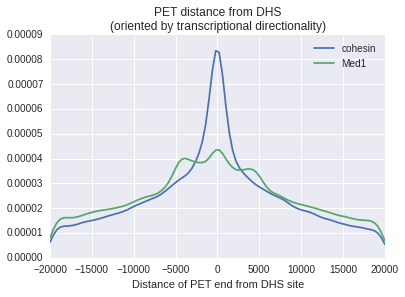

In [349]:
sns.distplot(cohesin_nums[np.abs(cohesin_nums) < 20000], label="cohesin", hist=False)
sns.distplot(nums[np.abs(nums) < 20000], label="Med1", hist=False)
sns.plt.xlabel("Distance of PET end from DHS site")
sns.plt.title("PET distance from DHS\n(oriented by transcriptional directionality)")

In [149]:
len(cohesin_nums[(cohesin_nums>-5000) & (cohesin_nums<0)])  # 101819
len(cohesin_nums[(cohesin_nums>0) & (cohesin_nums<5000)])  # 96180
len(cohesin_nums[(cohesin_nums>-2500) & (cohesin_nums<0)])  # 65782
len(cohesin_nums[(cohesin_nums>0) & (cohesin_nums<2500)])  # 62064  --> slight bias towards non-transcribed side

823173

In [117]:
len(cohesin_nums)  # 800k
len(cohesin_nums[np.abs(cohesin_nums)<5000])  # 198K out of 800K are within 5kb
len(cohesin_nums[np.abs(cohesin_nums)<10000])  # 302K out of 800K are within 10kb
len(cohesin_nums[np.abs(cohesin_nums)<20000])  # 429K out of 800K are within 20kb
len(cohesin_nums[np.abs(cohesin_nums)<50000])  # 601K out of 800K are within 50kb
len(cohesin_nums[np.abs(cohesin_nums)<100000])  # 707K out of 800K are within 100kb

706951

### Todo:

* run on a lot more data (e.g. all PETs)
* stratify by degree of DHS directionality (maybe super heavily directionally transcribed DHS's will have more of an effect)
* do lots of resampling
* do for all 5 datasets as a mode of characterization (how closely are PETs spaced around a DHS?)

### Actually run PET annotation for all 5 datasets

In [44]:
## DO NOT RUN HERE; RUN IN NOHUP ON CMD LINE ##
! awk -F '\t' 'BEGIN {OFS="\t"} {print $2, $3, $3 +1} {print $5, $6, $6 + 1}' \
data/loops/v65_7SK_merge_allValidPairs > interm/nb3/v65_7SK_merge_allValidPairs.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {print $2, $3, $3 +1} {print $5, $6, $6 + 1}' \
data/loops/v65_cohesin_merge_allValidPairs > interm/nb3/v65_cohesin_merge_allValidPairs.bed

## Contacts >20kb
! awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
data/loops/v65_7SK_merge_allValidPairs > interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
data/loops/v65_cohesin_merge_allValidPairs > interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
data/loops/v65_oct4_merge_allValidPairs > interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
data/loops/v65_H3K27ac_merge_allValidPairs > interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {if ($6 - $3 > 20000) print $2, $3, $3 +1, "\n" $5, $6, $6 + 1}' \
data/loops/v65_Med1_merge_allValidPairs > interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.bed

SyntaxError: invalid syntax (<ipython-input-44-7b628b36a620>, line 2)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [ ]:
## ALSO DO NOT RUN HERE; RUN IN NOHUP ON CMD LINE ##
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_7SK_merge_allValidPairs.bed > interm/nb3/v65_7SK_merge_allValidPairs.sorted.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_cohesin_merge_allValidPairs.bed > interm/nb3/v65_cohesin_merge_allValidPairs.sorted.bed
! rm -f interm/nb3/v65_7SK_merge_allValidPairs.bed
! rm -f interm/nb3/v65_cohesin_merge_allValidPairs.bed
! bedtools genomecov -i interm/nb3/v65_7SK_merge_allValidPairs.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' > \
interm/nb3/v65_7SK_merge_allValidPairs_filtered5.bedGraph
! bedtools genomecov -i interm/nb3/v65_cohesin_merge_allValidPairs.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_cohesin_merge_allValidPairs_filtered5.bedGraph
! rm -f interm/nb3/v65_7SK_merge_allValidPairs.sorted.bed
! rm -f interm/nb3/v65_cohesin_merge_allValidPairs.sorted.bed

In [ ]:
## ONLY CONTACTS >20KB; RUN IN NOHUP AS WELL ##
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.bed > interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.bed > interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.bed > interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.bed > interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted.bed
! ~/software/coreutils-8.9/src/sort -k1,1 --parallel=8 \
interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.bed > interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted.bed

! rm -f interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.bed
! rm -f interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.bed
! rm -f interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.bed
! rm -f interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.bed
! rm -f interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.bed

! bedtools genomecov -i interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_filtered5.bedGraph
! bedtools genomecov -i interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_filtered5.bedGraph
! bedtools genomecov -i interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_filtered5.bedGraph
! bedtools genomecov -i interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_filtered5.bedGraph
! bedtools genomecov -i interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted.bed \
-g data/mm9.sizes -bg | awk -F '\t' 'BEGIN {OFS="\t"} {if ($4 > 5) print $0}' \
> interm/nb3/v65_Med1_merge_allValidPairs_gt20kb_filtered5.bedGraph

In [ ]:
# 6/4: resort everything as -k2,2n just to start looking at distance from DHS
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted.bed > interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted12.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted.bed > interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted12.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted.bed > interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted12.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted.bed > interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted12.bed
! ~/software/coreutils-8.9/src/sort -k1,1 -k2,2n --parallel=8 \
interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted.bed > interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted12.bed

In [ ]:
# Normalize bedgraphs; also run as nohup
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_cohesin_merge_allValidPairs_filtered5.bedGraph \
interm/nb3/v65_cohesin_merge_allValidPairs_filtered5_norm.bedGraph 
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_7SK_merge_allValidPairs_filtered5.bedGraph \
interm/nb3/v65_7SK_merge_allValidPairs_filtered5_norm.bedGraph 
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_7SK_merge_allValidPairs_filtered10.bedGraph \
interm/nb3/v65_7SK_merge_allValidPairs_filtered10_norm.bedGraph
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_filtered5.bedGraph \
interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_filtered5_norm.bedGraph 
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_filtered5.bedGraph \
interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_filtered5_norm.bedGraph
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_filtered5.bedGraph \
interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_filtered5_norm.bedGraph 
! perl /home/raflynn/Scripts/chirpseq_analysis/norm_bedGraph.pl interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_filtered5.bedGraph \
interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_filtered5_norm.bedGraph 

**Metagenes of HiChIP and HiChIRP at promoters, enhancers, and ctcf/cohesin peaks**

cohesin: /home/mumbach/HiChIP/Regions/Kagey10_smc1a_rep1_genome_shifted_peaks.bed --> interm/nb3/Kagey10_smc1a_peaks.bed

7SK: /arrayAhome/raflynn/7SK/ChIRPseq/other_analyses/peaks/mES_WT_peaks_BED6.bed

promoters: mm9_tss_startseq_centered_1kb.bed

se: mES_SE_individual_1kb_BED6.bed

enhancers: mES_reg_enhancers_RY_startseq_centered_1kb.bed

In [ ]:
! metagene_maker -p 12 interm/nb3/160521_mm9_hichip_hichirp_1D.txt mm9_1dloops interm/metagenes

**Assign both sides of a valid pair loop to a DHS site:**
- run bedtools intersect on a sorted version of each side, store position (round to 10s place?) --> DHS for each
- then run through the whole file and
    - only take contacts >20kb
    - only keep pairs that have both boundaries falling in a DHS
    - label each cohesin or 7SK pair
- count the number of pairs for each interaction type
- make plots quantifying each (??) maybe signal doesn't really matter here

In [ ]:
# expand DHS window because effective resolution is Mbo1 restriction sites
# TODO: remove overlapping DHS's but right now its ok
! awk -F '\t' 'BEGIN {OFS="\t"} {print $1,$2-4000,$3+4000,$4,$5,$6}' \
interm/nb1/160504_dhs_grodirec_sorted.bed > interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {print $1,$2-19000,$3+19000,$4,$5,$6}' \
interm/nb1/160504_dhs_grodirec_sorted.bed > interm/nb1/160504_dhs_grodirec_sorted_pm20kb.bed
! awk -F '\t' 'BEGIN {OFS="\t"} {print $1,$2+1000,$3-999,$4,$5,$6}' \
interm/nb1/160504_dhs_grodirec_sorted.bed > interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed

In [ ]:
! bedtools intersect -a interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted_dhs.bed
! bedtools intersect -a interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted_dhs.bed
! bedtools intersect -a interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted_dhs.bed
! bedtools intersect -a interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted_dhs.bed
! bedtools intersect -a interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted.bed \
-b interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed -wb | awk 'OFS="\t" {print $1,$2,$3,$7}' \
> interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted_dhs.bed

In [ ]:
# 20KB DHS'S: is bedtools closest slower than intersect? no, after you do sorting k1,1 k2,2n it's pretty fast
! uniq interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted12.bed | bedtools closest -a stdin \
-b interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5,$7,$9}' \
> interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted_dhs_closest.bed
! uniq interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted12.bed | bedtools closest -a stdin \
-b interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5,$7,$9}' \
> interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted_dhs_closest.bed
! uniq interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted12.bed | bedtools closest -a stdin \
-b interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5,$7,$9}' \
> interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted_dhs_closest.bed
! uniq interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted12.bed | bedtools closest -a stdin \
-b interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5,$7,$9}' \
> interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted_dhs_closest.bed
! uniq interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted12.bed | bedtools closest -a stdin \
-b interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed -t first | awk 'OFS="\t" {print $1,$2,$3,$5,$7,$9}' \
> interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted_dhs_closest.bed

### Alternative strategy: just cache all 1kb blocks around all DHS's in a pos-to-DHS dictionary, then run through the allValidPairs --> no need to waste time on all of the above

### Use this instead of the above strategy!!

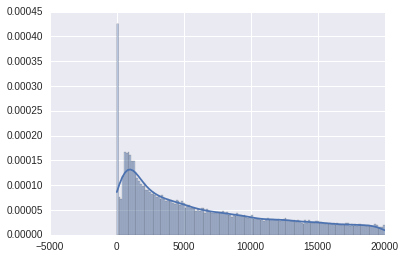

In [163]:
# how far apart are DHS's?
dist = []
init = 0
with open("interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dist.append(math.fabs(int(row[1]) - init))
        init = int(row[1])
dist = np.array(dist)
dist = dist[dist < 2e4]
sns.distplot(dist, bins=150)

In [220]:
# clean up DHS file

close_sets = []
new_set = []
dists = []
init = 0
with open("interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dist = math.fabs(int(row[1]) - init)
        init = int(row[1])
        if dist < 150:  # length of 1 nucleosome
            new_set.append(row)
        else:
            if len(new_set) > 1: close_sets.append(new_set)
            new_set = [row]
        dists.append(dist)

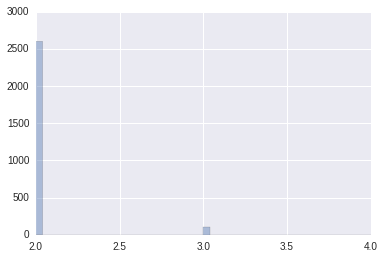

In [210]:
sns.distplot([len(x) for x in close_sets], kde=False)

In [254]:
dhs_to_gro = {}
with open("interm/nb1/160504_dhs_grodirec_data.txt", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    reader.next()
    for row in reader:
        dhs_to_gro[row[0]] = float(row[1])

In [265]:
# rules
# if 2:
#   if off by up to 50, take the first one
#   else: promoter > enhancer, active > poised/weak, strong > poised/weak
#   else: take higher groseq txn one
# promoter > enhancer
# 
to_delete = []
for c in close_sets:
    starts = [int(x[1]) for x in c]
    if len(c) == 2:
        if starts[1] - starts[0] <= 50:
            to_delete.append(c[1][3])
        else:
            if 'Promoter' in c[1][3] and 'Promoter' not in c[0][3]: to_delete.append(c[0][3])
            elif 'Promoter' in c[0][3] and 'Promoter' not in c[1][3]: to_delete.append(c[1][3])
            elif 'Enhancer' in c[1][3] and 'Enhancer' not in c[0][3]: to_delete.append(c[0][3])
            elif 'Enhancer' in c[0][3] and 'Enhancer' not in c[1][3]: to_delete.append(c[1][3])
            elif 'Active' in c[1][3] and 'Active' not in c[0][3]: to_delete.append(c[0][3])
            elif 'Active' in c[0][3] and 'Active' not in c[1][3]: to_delete.append(c[1][3])
            elif 'Strong' in c[1][3] and 'Strong' not in c[0][3]: to_delete.append(c[0][3])
            elif 'Strong' in c[0][3] and 'Strong' not in c[1][3]: to_delete.append(c[1][3])
            else:
                if dhs_to_gro[c[1][3]] > dhs_to_gro[c[0][3]]: to_delete.append(c[0][3])
                else: to_delete.append(c[1][3])
    if len(c) == 3:
        flag = 0
        if starts[1] - starts[0] < 50:
            to_delete.append(c[1][3])
            flag = 1
        if starts[2] - starts[1] < 50:
            to_delete.append(c[2][3])
            flag = 1
        if flag == 0:  # there are like 8 of these so fairly inconsequential, just take highest scorer
            groscores = [dhs_to_gro[c[i][3]] for i in range(3)]
            for i in range(3):
                if np.argmax(groscores) != i: to_delete.append(c[i][3])           
print len(to_delete)

2770


In [266]:
def write_new_file(oldfn, newfn, to_delete, colnum):
    with open(oldfn, 'r') as ifile, open(newfn, 'w') as ofile:
        reader = csv.reader(ifile, 'textdialect')
        writer = csv.writer(ofile, 'textdialect')
        for row in reader:
            if row[colnum] not in to_delete:
                writer.writerow(row)
                
write_new_file("interm/nb1/160504_dhs_grodirec_sorted.bed", "interm/nb1/160605_dhs_grodirec_sorted.bed", to_delete, 3)
write_new_file("interm/nb1/160504_dhs_grodirec_sorted_pm1bp.bed", "interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", to_delete, 3)
write_new_file("interm/nb1/160504_dhs_grodirec_sorted_pm5kb.bed", "interm/nb1/160605_dhs_grodirec_sorted_pm5kb.bed", to_delete, 3)
write_new_file("interm/nb1/160504_dhs_grodirec_sorted_pm20kb.bed", "interm/nb1/160605_dhs_grodirec_sorted_pm20kb.bed", to_delete, 3)
write_new_file("interm/nb1/160504_dhs_grodirec_data.txt", "interm/nb1/160605_dhs_grodirec_data.txt", to_delete, 0)

In [268]:
! wc -l interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed

70575 interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed


In [284]:
# for all 100bp blocks within 20kb of a DHS, cache its closest DHS

def lx():
    return {}

pos_to_dhs = collections.defaultdict(lx)  # chr --> pos --> dhs
dhsnum_to_dhs = {}
with open("interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        chrom = row[0]
        dhs = '__'.join(row[3].split('__')[4:6])
        dhsnum = int(dhs.split('__')[0].split('_')[1])
        dhsnum_to_dhs[dhsnum] = dhs
        pos = int(row[1])/100
        for i in range(-200,201):
            if pos + i not in pos_to_dhs[chrom] or pos_to_dhs[chrom][pos + i][1] > i:
                pos_to_dhs[chrom][pos + i] = [dhsnum, np.abs(i)]
pos_to_dhs_new = collections.defaultdict(lx)
for chrom in pos_to_dhs:
    for pos in pos_to_dhs[chrom]:
        pos_to_dhs_new[chrom][pos] = pos_to_dhs[chrom][pos][0]
pickle.dump((pos_to_dhs_new, dhsnum_to_dhs), open("interm/nb3/160605_pos_to_dhs.pkl", 'w'))

Reading in all the position to DHS sites takes about 2 minutes and 400M memory (mid-May when we only took 5kb DHS's)

In [ ]:
# OLD SCRIPTS (when we were using the old method to annotate PET ends)
# ! python scripts/annotate_loops.py interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted_dhs.bed \
# data/loops/v65_cohesin_merge_allValidPairs interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_labeledByDHS.pkl
# ! python scripts/annotate_loops.py interm/nb3/v65_7SK_merge_allValidPairs_gt20kb.sorted_dhs.bed \
# data/loops/v65_7SK_merge_allValidPairs interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_labeledByDHS.pkl
# ! python scripts/annotate_loops.py interm/nb3/v65_oct4_merge_allValidPairs_gt20kb.sorted_dhs.bed \
# data/loops/v65_oct4_merge_allValidPairs interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_labeledByDHS.pkl
# ! python scripts/annotate_loops.py interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb.sorted_dhs.bed \
# data/loops/v65_H3K27ac_merge_allValidPairs interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_labeledByDHS.pkl
# ! python scripts/annotate_loops.py interm/nb3/v65_Med1_merge_allValidPairs_gt20kb.sorted_dhs.bed \
# data/loops/v65_Med1_merge_allValidPairs interm/nb3/v65_Med1_merge_allValidPairs_gt20kb_labeledByDHS.pkl

# after running the above script the first time, the annotations for each position should be loaded in a pkl
# and you can run it like this:
! python scripts/annotate_loops.py interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb.sorted_dhs.pkl \
data/loops/v65_cohesin_merge_allValidPairs interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_labeledByDHS.pkl

# NEW
! python scripts/annotate_loops.py interm/nb3/160605_pos_to_dhs.pkl \
data/loops/v65_cohesin_merge_allValidPairs interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_labeledByDHS.pkl
! python scripts/annotate_loops.py interm/nb3/160605_pos_to_dhs.pkl \
data/loops/v65_7SK_merge_allValidPairs interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_labeledByDHS.pkl
! python scripts/annotate_loops.py interm/nb3/160605_pos_to_dhs.pkl \
data/loops/v65_oct4_merge_allValidPairs interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_labeledByDHS.pkl
! python scripts/annotate_loops.py interm/nb3/160605_pos_to_dhs.pkl \
data/loops/v65_H3K27ac_merge_allValidPairs interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_labeledByDHS.pkl
! python scripts/annotate_loops.py interm/nb3/160605_pos_to_dhs.pkl \
data/loops/v65_Med1_merge_allValidPairs interm/nb3/v65_Med1_merge_allValidPairs_gt20kb_labeledByDHS.pkl

## Necessary functions for analysis of datasets

In [108]:
# necessary functions for the defaultdicts inside the pkl files

def l():
    return 0

def ll():
    return collections.defaultdict(l)

In [109]:
# get DHS to chromosome
dhs_to_chr = {}
with open("interm/nb1/160605_dhs_grodirec_sorted.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dhs = '__'.join(row[3].split('__')[4:6])
        dhs_to_chr[dhs] = row[0]

In [110]:
# Scale by the number of each DHS type
with open("interm/nb1/160605_dhs_grodirec_sorted.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    region_to_num = collections.defaultdict(lambda: 0)
    for row in reader:
        regionType = '_'.join(row[3].split('__')[5].split('_')[1:])
        region_to_num[regionType] += 1
region_to_num

defaultdict(<function __main__.<lambda>>,
            {'Active_Promoter': 16506,
             'Heterochrom': 18169,
             'Insulator': 7966,
             'Poised_Enhancer': 673,
             'Poised_Promoter': 3228,
             'Repressed': 3083,
             'Strong_Enhancer': 13667,
             'Txn_Elongation': 2318,
             'Txn_Transition': 1512,
             'Weak_Txn': 3453})

### Analysis of cohesin loops

In [111]:
(cohesin_data, dhsnum_to_dhs, total_good, twentyctr, ctr) = \
pickle.load(open("interm/nb3/v65_cohesin_merge_allValidPairs_gt20kb_labeledByDHS.pkl", 'r'))
print "Total loops: {}".format(ctr)
print "Total >20kb loops: {}".format(twentyctr)
print "Total >20kb loops with DHS on both sides: {}".format(total_good)

Total loops: 243950274
Total >20kb loops: 163826832
Total >20kb loops with DHS on both sides: 72766430


In [318]:
# Figure out how often different region types bind to different region types
region_to_region = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
region_to_region_uniq = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for dhs in cohesin_data:
    dhsname = dhsnum_to_dhs[dhs]
    region = '_'.join(dhsname.split('__')[1].split('_')[1:])
    for partner in cohesin_data[dhs]:
        partnername = dhsnum_to_dhs[partner]
        if cohesin_data[dhs][partner] < 200: continue
        if dhs_to_chr[dhsname] != dhs_to_chr[partnername]: continue  # trans
        partner_region = '_'.join(partnername.split('__')[1].split('_')[1:])
        region_to_region[region][partner_region] += cohesin_data[dhs][partner]
        region_to_region[partner_region][region] += cohesin_data[dhs][partner]
        region_to_region_uniq[region][partner_region] += 1
        region_to_region_uniq[partner_region][region] += 1

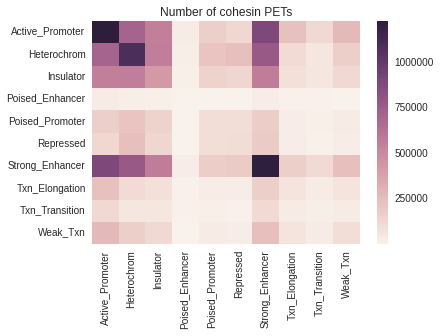

In [319]:
df = pd.DataFrame(region_to_region)
sns.heatmap(df)
sns.plt.title("Number of cohesin PETs")

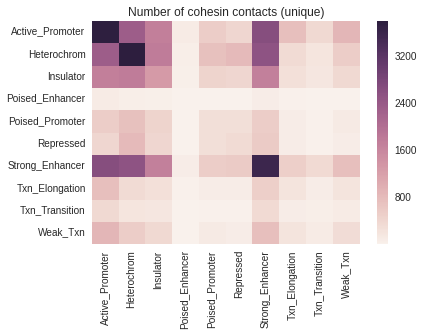

In [320]:
dfu = pd.DataFrame(region_to_region_uniq)
sns.heatmap(dfu)
sns.plt.title("Number of cohesin contacts (unique)")

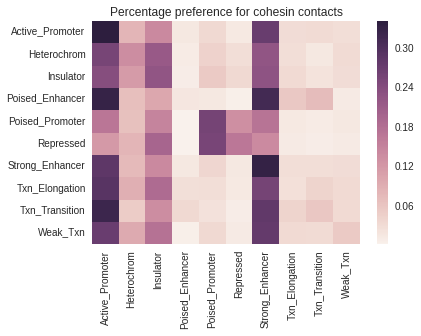

In [223]:
df_scaled = pd.DataFrame(region_to_region).apply(lambda x: x/np.sum(x), axis=1)
sns.heatmap(df_scaled)
sns.plt.title("Percentage preference for cohesin contacts")

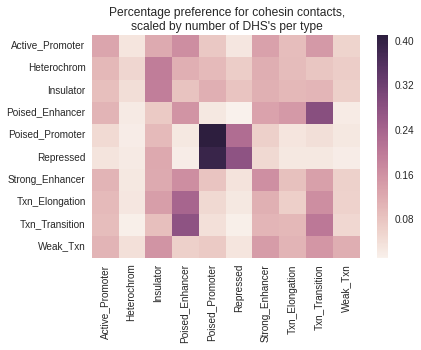

In [224]:
num_reg = [region_to_num[x] for x in df.index]
def scale(x):
    z = x/num_reg
    return z/np.sum(z)
df_scaled_bynum = pd.DataFrame(region_to_region).apply(scale, axis=1)
sns.heatmap(df_scaled_bynum)
sns.plt.title("Percentage preference for cohesin contacts,\nscaled by number of DHS's per type")

### Analysis of 7SK loops

In [112]:
(sevensk_data, dhsnum_to_dhs, total_good, twentyctr, ctr) = \
pickle.load(open("interm/nb3/v65_7SK_merge_allValidPairs_gt20kb_labeledByDHS.pkl", 'r'))
print "Total loops: {}".format(ctr)
print "Total >20kb loops: {}".format(twentyctr)
print "Total >20kb loops with DHS on both sides: {}".format(total_good)

Total loops: 267045712
Total >20kb loops: 135619605
Total >20kb loops with DHS on both sides: 91214475


In [311]:
# Figure out how often different region types bind to different region types
region_to_region = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
region_to_region_uniq = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for dhs in sevensk_data:
    dhsname = dhsnum_to_dhs[dhs]
    region = '_'.join(dhsname.split('__')[1].split('_')[1:])
    for partner in sevensk_data[dhs]:
        partnername = dhsnum_to_dhs[partner]
        if sevensk_data[dhs][partner] < 200: continue
        if dhs_to_chr[dhsname] != dhs_to_chr[partnername]: continue  # trans
        partner_region = '_'.join(partnername.split('__')[1].split('_')[1:])
        region_to_region[region][partner_region] += sevensk_data[dhs][partner]
        region_to_region[partner_region][region] += sevensk_data[dhs][partner]
        region_to_region_uniq[region][partner_region] += 1
        region_to_region_uniq[partner_region][region] += 1

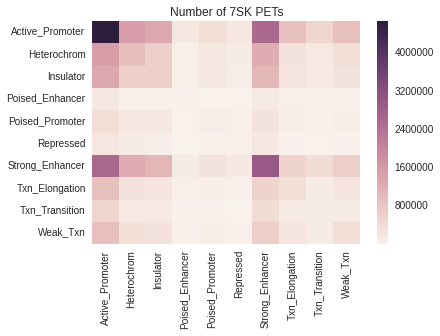

In [312]:
df = pd.DataFrame(region_to_region)
sns.heatmap(df)
sns.plt.title("Number of 7SK PETs")

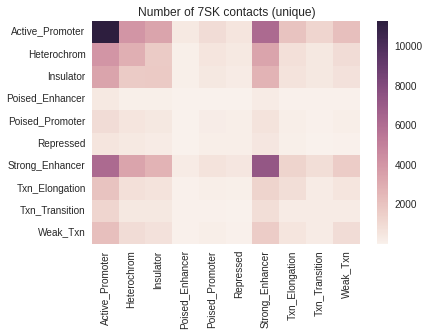

In [313]:
dfu = pd.DataFrame(region_to_region_uniq)
sns.heatmap(dfu)
sns.plt.title("Number of 7SK contacts (unique)")

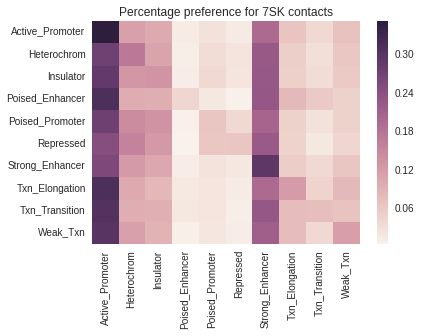

In [314]:
df_scaled = pd.DataFrame(region_to_region).apply(lambda x: x/np.sum(x), axis=1)
sns.heatmap(df_scaled)
sns.plt.title("Percentage preference for 7SK contacts")

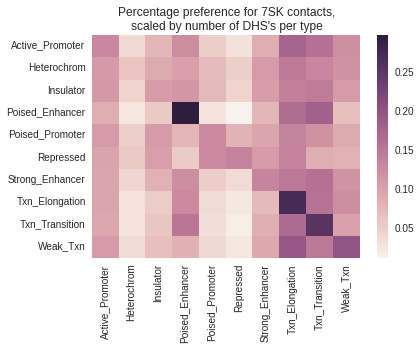

In [315]:
num_reg = [region_to_num[x] for x in df.index]
def scale(x):
    z = x/num_reg
    return z/np.sum(z)
df_scaled_bynum = pd.DataFrame(region_to_region).apply(scale, axis=1)
sns.heatmap(df_scaled_bynum)
sns.plt.title("Percentage preference for 7SK contacts,\nscaled by number of DHS's per type")

### Analysis of Oct4 loops

In [113]:
(oct4_data, dhsnum_to_dhs, total_good, twentyctr, ctr) = \
pickle.load(open("interm/nb3/v65_oct4_merge_allValidPairs_gt20kb_labeledByDHS.pkl", 'r'))
print "Total PETs: {}".format(ctr)
print "Total >20kb PETs: {}".format(twentyctr)
print "Total >20kb PETs with DHS on both sides: {}".format(total_good)

Total PETs: 163535394
Total >20kb PETs: 118933726
Total >20kb PETs with DHS on both sides: 45773348


In [305]:
# Figure out how often different region types bind to different region types
region_to_region = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
region_to_region_uniq = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for dhs in oct4_data:
    dhsname = dhsnum_to_dhs[dhs]
    region = '_'.join(dhsname.split('__')[1].split('_')[1:])
    for partner in oct4_data[dhs]:
        partnername = dhsnum_to_dhs[partner]
        if oct4_data[dhs][partner] < 200: continue
        if dhs_to_chr[dhsname] != dhs_to_chr[partnername]: continue  # trans
        partner_region = '_'.join(partnername.split('__')[1].split('_')[1:])
        region_to_region[region][partner_region] += oct4_data[dhs][partner]
        region_to_region[partner_region][region] += oct4_data[dhs][partner]
        region_to_region_uniq[region][partner_region] += 1
        region_to_region_uniq[partner_region][region] += 1

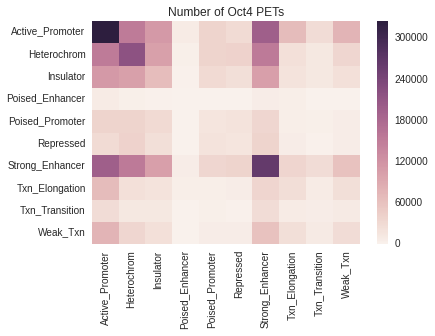

In [306]:
df = pd.DataFrame(region_to_region)
sns.heatmap(df)
sns.plt.title("Number of Oct4 PETs")

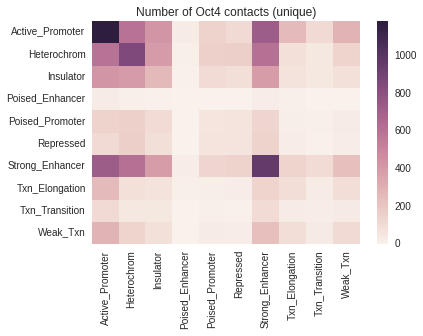

In [307]:
dfu = pd.DataFrame(region_to_region_uniq)
sns.heatmap(dfu)
sns.plt.title("Number of Oct4 contacts (unique)")

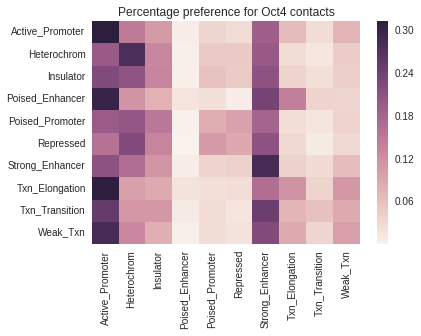

In [308]:
df_scaled = pd.DataFrame(region_to_region).apply(lambda x: x/np.sum(x), axis=1)
sns.heatmap(df_scaled)
sns.plt.title("Percentage preference for Oct4 contacts")

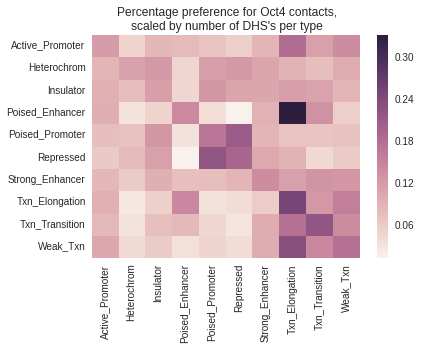

In [309]:
num_reg = [region_to_num[x] for x in df.index]
def scale(x):
    z = x/num_reg
    return z/np.sum(z)
df_scaled_bynum = pd.DataFrame(region_to_region).apply(scale, axis=1)
sns.heatmap(df_scaled_bynum)
sns.plt.title("Percentage preference for Oct4 contacts,\nscaled by number of DHS's per type")

### Analysis of H3K27ac loops

In [114]:
(k27_data, dhsnum_to_dhs, total_good, twentyctr, ctr) = \
pickle.load(open("interm/nb3/v65_H3K27ac_merge_allValidPairs_gt20kb_labeledByDHS.pkl", 'r'))
print "Total PETs: {}".format(ctr)
print "Total >20kb PETs: {}".format(twentyctr)
print "Total >20kb PETs with DHS on both sides: {}".format(total_good)

Total PETs: 355514969
Total >20kb PETs: 272541322
Total >20kb PETs with DHS on both sides: 136394976


In [337]:
# Figure out how often different region types bind to different region types
region_to_region = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
region_to_region_uniq = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for dhs in k27_data:
    dhsname = dhsnum_to_dhs[dhs]
    region = '_'.join(dhsname.split('__')[1].split('_')[1:])
    for partner in k27_data[dhs]:
        partnername = dhsnum_to_dhs[partner]
        if k27_data[dhs][partner] < 400: continue
        if dhs_to_chr[dhsname] != dhs_to_chr[partnername]: continue  # trans
        partner_region = '_'.join(partnername.split('__')[1].split('_')[1:])
        region_to_region[region][partner_region] += k27_data[dhs][partner]
        region_to_region[partner_region][region] += k27_data[dhs][partner]
        region_to_region_uniq[region][partner_region] += 1
        region_to_region_uniq[partner_region][region] += 1

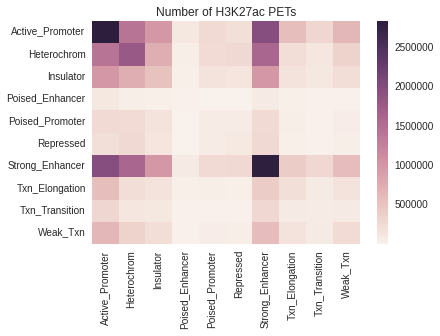

In [335]:
df = pd.DataFrame(region_to_region)
sns.heatmap(df)
sns.plt.title("Number of H3K27ac PETs")

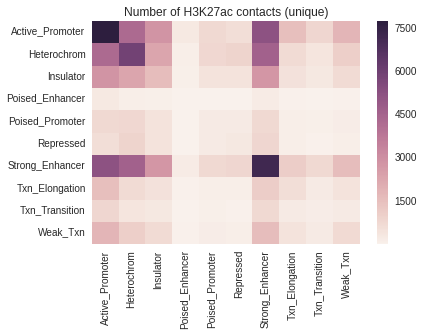

In [336]:
dfu = pd.DataFrame(region_to_region_uniq)
sns.heatmap(dfu)
sns.plt.title("Number of H3K27ac contacts (unique)")

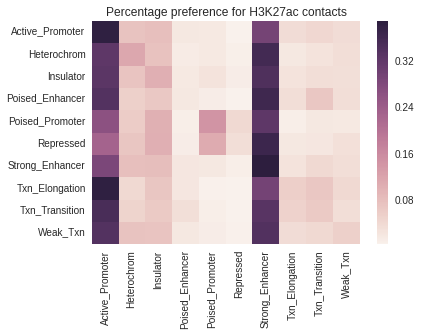

In [210]:
df_scaled = pd.DataFrame(region_to_region).apply(lambda x: x/np.sum(x), axis=1)
sns.heatmap(df_scaled)
sns.plt.title("Percentage preference for H3K27ac contacts")

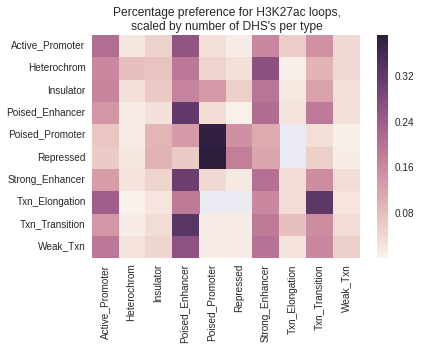

In [163]:
num_reg = [region_to_num[x] for x in df.index]
def scale(x):
    z = x/num_reg
    return z/np.sum(z)
df_scaled_bynum = pd.DataFrame(region_to_region).apply(scale, axis=1)
sns.heatmap(df_scaled_bynum)
sns.plt.title("Percentage preference for H3K27ac contacts,\nscaled by number of DHS's per type")

### Analysis of Med1 loops

In [115]:
(med1_data, dhsnum_to_dhs, total_good, twentyctr, ctr) = \
pickle.load(open("interm/nb3/v65_Med1_merge_allValidPairs_gt20kb_labeledByDHS.pkl", 'r'))
print "Total loops: {}".format(ctr)
print "Total >20kb loops: {}".format(twentyctr)
print "Total >20kb loops with DHS on both sides: {}".format(total_good)

Total loops: 379847454
Total >20kb loops: 307984892
Total >20kb loops with DHS on both sides: 109383464


In [332]:
# Figure out how often different region types bind to different region types
region_to_region = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
region_to_region_uniq = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for dhs in med1_data:
    dhsname = dhsnum_to_dhs[dhs]
    region = '_'.join(dhsname.split('__')[1].split('_')[1:])
    for partner in med1_data[dhs]:
        partnername = dhsnum_to_dhs[partner]
        if med1_data[dhs][partner] < 200: continue
        if dhs_to_chr[dhsname] != dhs_to_chr[partnername]: continue  # trans
        partner_region = '_'.join(partnername.split('__')[1].split('_')[1:])
        region_to_region[region][partner_region] += med1_data[dhs][partner]
        region_to_region[partner_region][region] += med1_data[dhs][partner]
        region_to_region_uniq[region][partner_region] += 1
        region_to_region_uniq[partner_region][region] += 1

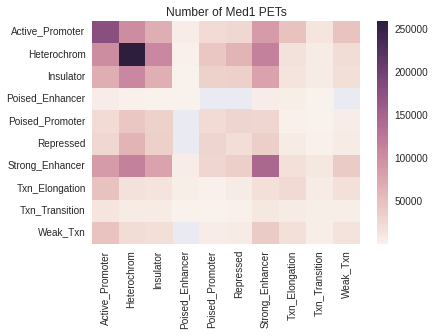

In [328]:
df = pd.DataFrame(region_to_region)
sns.heatmap(df)
sns.plt.title("Number of Med1 PETs")

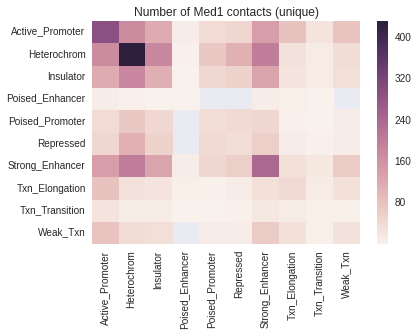

In [329]:
dfu = pd.DataFrame(region_to_region_uniq)
sns.heatmap(dfu)
sns.plt.title("Number of Med1 contacts (unique)")

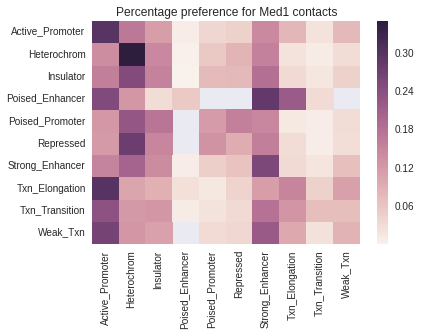

In [330]:
df_scaled = pd.DataFrame(region_to_region).apply(lambda x: x/np.sum(x), axis=1)
sns.heatmap(df_scaled)
sns.plt.title("Percentage preference for Med1 contacts")

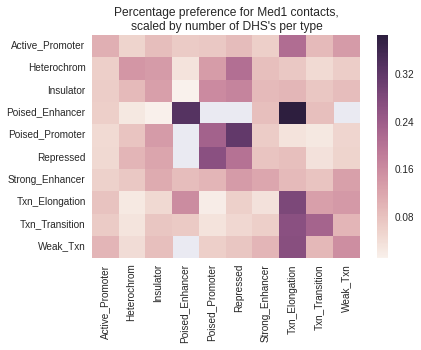

In [331]:
num_reg = [region_to_num[x] for x in df.index]
def scale(x):
    z = x/num_reg
    return z/np.sum(z)
df_scaled_bynum = pd.DataFrame(region_to_region).apply(scale, axis=1)
sns.heatmap(df_scaled_bynum)
sns.plt.title("Percentage preference for Med1 contacts,\nscaled by number of DHS's per type")

## Comparison of different datasets

### Lengths of loops

I haven't done this

### Only looking at contacts within promoters and enhancers

In [116]:
exps = [cohesin_data, sevensk_data, oct4_data, k27_data, med1_data]

pp = {}
pe = {}
ee = {}

def getval(experiment, dhs, partner):
    try: return experiment[dhs][partner]
    except: return 0
    
dhsnum_to_dhs = {}
dhsnum_to_chr = {}
with open("interm/nb1/160605_dhs_grodirec_sorted.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dhsnum = int(row[3].split('__')[4].split('_')[1])
        dhsnum_to_dhs[dhsnum] = row[3]
        dhsnum_to_chr[dhsnum] = row[3].split('__')[0]

In [137]:
for i in range(len(exps)):
    print i
    exp = exps[i]
    for dhs in exp:
        dhsname = dhsnum_to_dhs[dhs]
        region = '_'.join(dhsname.split('__')[5].split('_')[1:])
        if 'Promoter' in region: r1 = 'p'
        elif 'Enhancer' in region: r1 = 'e'
        else: continue
        for partner in exp[dhs]:
            partnername = dhsnum_to_dhs[partner]
            if dhsnum_to_chr[dhs] != dhsnum_to_chr[partner]: continue
            if dhs == partner: continue
            
            partner_region = '_'.join(partnername.split('__')[5].split('_')[1:])
            if 'Promoter' in partner_region: r2 = 'p'
            elif 'Enhancer' in partner_region: r2 = 'e'
            else: continue

            if r1 == 'e' and r2 == 'p': 
                key = '{}___{}'.format(partner, dhs)
                if key in pe: continue
                x = [getval(experiment, dhs, partner) for experiment in exps]
                if max(x) > 19: pe[key] = x
            elif r1 == 'p' and r2 == 'e': 
                key = '{}___{}'.format(dhs, partner)
                if key in pe: continue
                x = [getval(experiment, dhs, partner) for experiment in exps]
                if max(x) > 19: pe[key] = x
            elif r1 == 'p' and r2 == 'p': 
                key = '{}___{}'.format(dhs, partner)
                if key in pp: continue
                x = [getval(experiment, dhs, partner) for experiment in exps]
                if max(x) > 19: pp[key] = x
            elif r1 == 'e' and r2 == 'e': 
                key = '{}___{}'.format(dhs, partner)
                if key in ee: continue
                x = [getval(experiment, dhs, partner) for experiment in exps]
                if max(x) > 19: ee[key] = x
                    
pickle.dump((pp, pe, ee), open("interm/nb3/pp_pe_ee.pkl", 'w'))

0
1
2
3
4


In [2]:
# function for ranking each column and then slapping the ranks onto a normal distribution

def normalize_df(df):
    for c in df.columns:
        col = df[c]
        r = np.argsort(np.argsort(col))
        rn = r/float(np.max(r))*0.98 + 0.01  # [0.01,0.99]
        df[c] = [scipy.stats.norm.ppf(i) for i in rn]  # mean 0, sd 1        

In [2]:
(pp, pe, ee) = pickle.load(open("interm/nb3/pp_pe_ee.pkl", 'r'))

In [138]:
pp_df = pd.DataFrame.from_dict(pp, orient='index')
print pp_df.shape

(73945, 5)


In [139]:
pp_dfnorm = pp_df.copy()
normalize_df(pp_dfnorm)
pp_dfnorm.head()

,0,1,2,3,4
174___183,1.440886,1.163133,1.569705,1.258174,1.592074
174___181,1.310933,1.102247,1.649513,1.224860,1.598120
84795___84822,0.730175,0.224588,0.863557,0.857639,0.853137
78494___78615,-1.533828,-0.356319,-1.516397,-1.450331,-1.619324
84194___84215,-0.587230,-0.542070,-0.381175,-1.152935,-0.095356


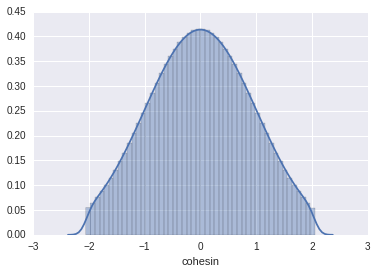

In [422]:
sns.distplot(pp_dfnorm["cohesin"])

In [140]:
pe_df = pd.DataFrame.from_dict(pe, orient='index')
pe_dfnorm = pe_df.copy()
normalize_df(pe_dfnorm)
print pe_df.shape

(91342, 5)


In [141]:
ee_df = pd.DataFrame.from_dict(ee, orient='index')
ee_dfnorm = ee_df.copy()
normalize_df(ee_dfnorm)
cols = ['cohesin', 'sevensk', 'oct4', 'k27ac', 'med1']
pp_df.columns = pe_df.columns = ee_df.columns = cols
pp_dfnorm.columns = pe_dfnorm.columns = ee_dfnorm.columns = cols
print ee_df.shape

(43873, 5)


In [142]:
pp_df.to_csv("interm/nb3/promoter_promoter_contact_strengths.txt", sep='\t')
pe_df.to_csv("interm/nb3/promoter_enhancer_contact_strengths.txt", sep='\t')
ee_df.to_csv("interm/nb3/enhancer_enhancer_contact_strengths.txt", sep='\t')
pp_dfnorm.to_csv("interm/nb3/promoter_promoter_norm_contact_strengths.txt", sep='\t')
pe_dfnorm.to_csv("interm/nb3/promoter_enhancer_norm_contact_strengths.txt", sep='\t')
ee_dfnorm.to_csv("interm/nb3/enhancer_enhancer_norm_contact_strengths.txt", sep='\t')
pickle.dump((pp_df, pp_dfnorm, pe_df, pe_dfnorm, ee_df, ee_dfnorm), open("interm/nb3/pp_pe_ee_counts_ranks.pkl", 'w'))

### Things I can do

* number of PP, PE, and EE loops that are specific to each / what is the pairwise overlap? 4-way Venn diagram
* distribution: number of enhancers looped to by each promoter, number of promoters looped to each promoter, etc for each dataset
* gene factories? densely connected networks?
* directionality: super stable P/E loops (cohesin) and less stable ones (7SK, etc)
* within TADs/large cohesin loops do things have similar directionalities? are there directionality preferences for contacts?  -- will need to get TADs somewhere

In [90]:
(pp_df, pp_dfnorm, pe_df, pe_dfnorm, ee_df, ee_dfnorm) = pickle.load(open("interm/nb3/pp_pe_ee_counts_ranks.pkl", 'r'))

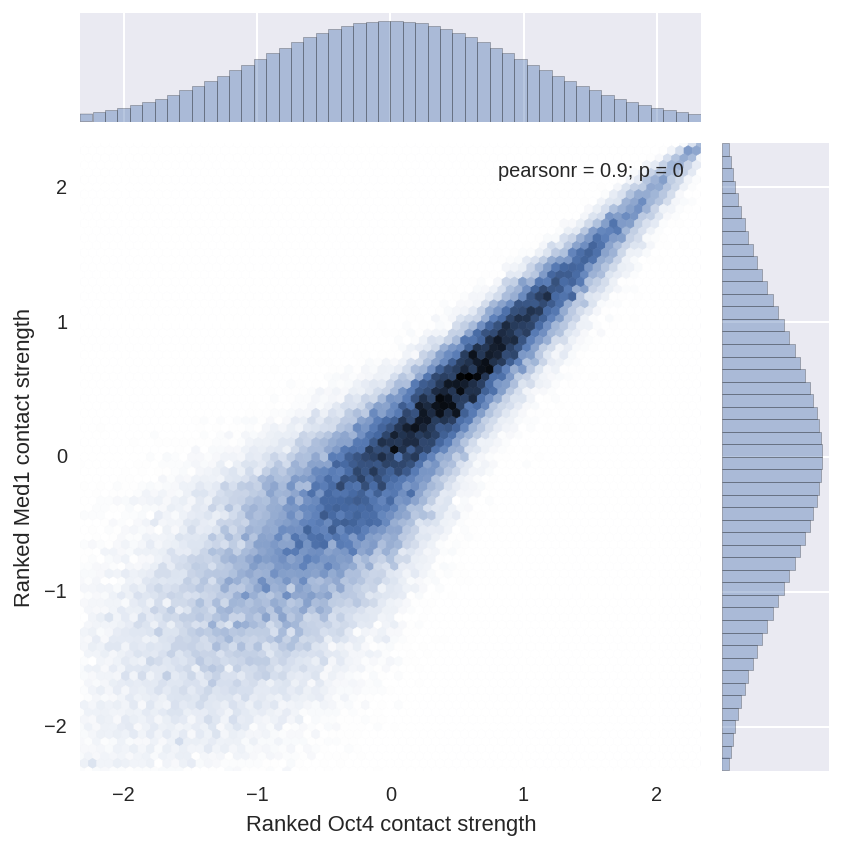

In [124]:
sns.jointplot("oct4", "med1", data=pp_dfnorm, kind="hex").\
set_axis_labels("Ranked Oct4 contact strength", "Ranked Med1 contact strength")

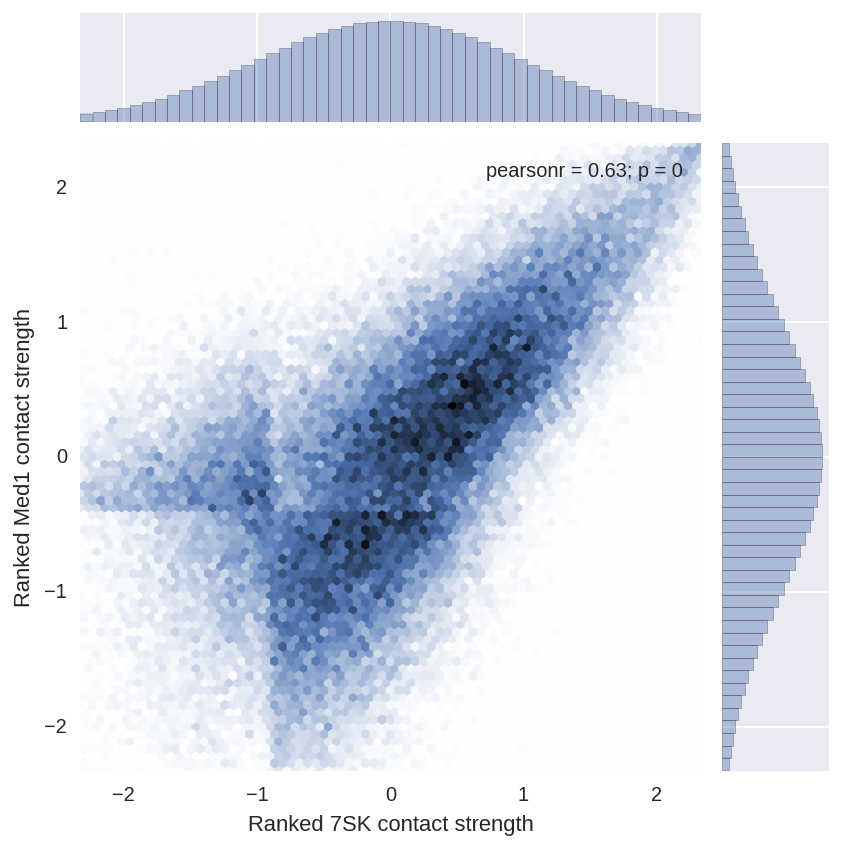

In [125]:
sns.jointplot("sevensk", "med1", data=pp_dfnorm, kind="hex").\
set_axis_labels("Ranked 7SK contact strength", "Ranked Med1 contact strength")

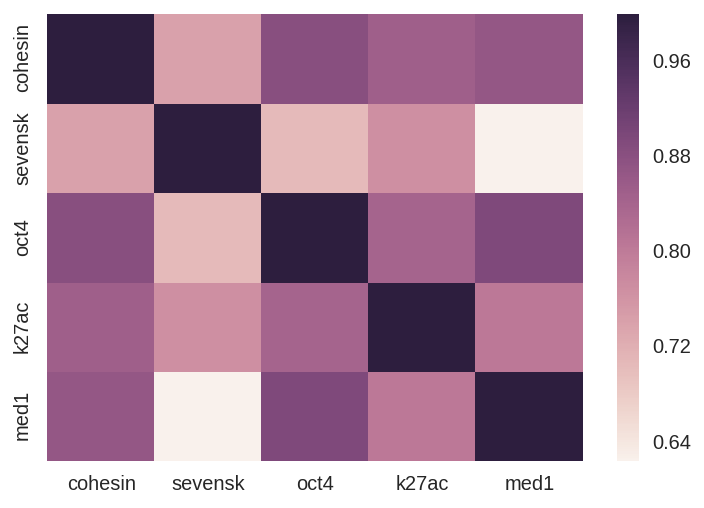

In [18]:
sns.heatmap(pp_dfnorm.corr())

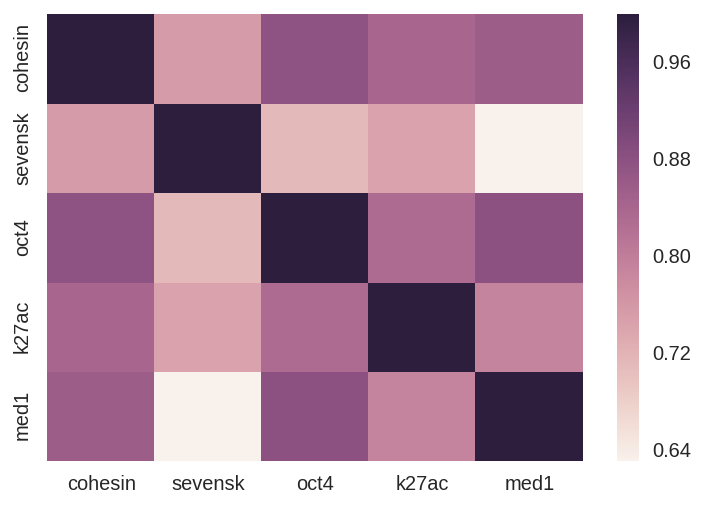

In [20]:
sns.heatmap(pe_dfnorm.corr())

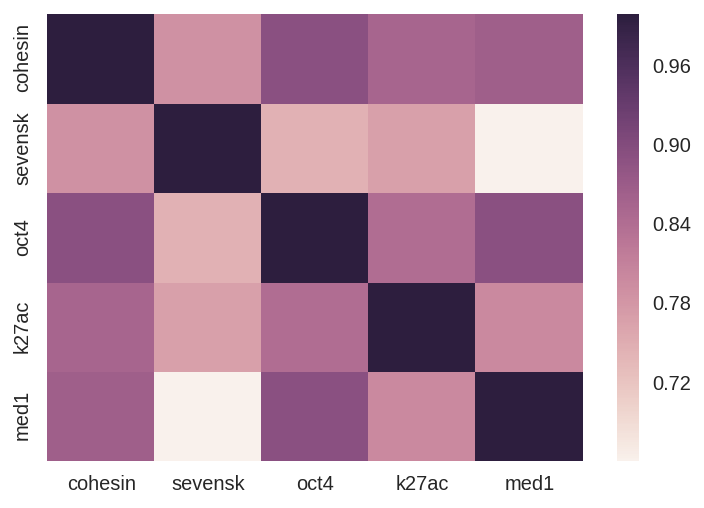

In [21]:
sns.heatmap(ee_dfnorm.corr())

When looking at rank of binding strengths:

* 7SK and Med1 co-bind the least; the strongest cobinding pairs are cohesin and Oct4, Med1 and Oct4, and cohesin and Med1. 
* Indeed, when we cluster the three heatmaps, we see that cohesin, Med1, and Oct4 cluster together while 7SK and K27ac cluster together. 

In [127]:
print [(x, pp_df[(pp_df[x]>19)].shape[0]) for x in pp_df.columns]

[('cohesin', 43158), ('sevensk', 60843), ('oct4', 29438), ('k27ac', 60903), ('med1', 48597)]


In [128]:
print pp_df[(pp_df["med1"]>19) & (pp_df["oct4"]>19) & (pp_df["sevensk"]>19) & (pp_df["cohesin"]>19) & (pp_df["k27ac"]>19)].shape[0]

27591


In [129]:
print pp_df[(pp_df["k27ac"]>19) & (pp_df["sevensk"]>19)].shape[0]

51029


In [130]:
print pp_df[(pp_df["sevensk"]>19) & (pp_df["cohesin"]>19) & (pp_df["k27ac"]>19)].shape[0]

38863


* Almost all Oct4 promoter-promoter contacts are co-bound by all 5 
* There is an 80% overlap between K27ac and 7SK contacts; this might not be statistically significant given the presence of only 77,000 total contacts
* Cohesin contacts are almost a complete subset of K27ac/7SK contacts; more stable? Most cohesin contacts also have K27ac and cohesin

### Global characterization of P-P, P-E, and E-E

In [131]:
# Scale by the number of each DHS type
dhsnum_to_type = {}
dhsnum_to_info = {}
type_to_num = collections.defaultdict(lambda: 0)
with open("interm/nb1/160605_dhs_grodirec_sorted.bed", 'r') as ifile:
    reader = csv.reader(ifile, 'textdialect')
    for row in reader:
        dhsnum = row[3].split('__')[4].split('_')[-1]
        regionType = row[3].split('__')[5].split('_')[-1]
        dhsnum_to_type[dhsnum] = regionType
        dhsnum_to_info[dhsnum] = ' '.join(row[3].split('__')[:3])
        type_to_num[regionType] += 1
        
type_to_num

defaultdict(<function __main__.<lambda>>,
            {'Elongation': 2318,
             'Enhancer': 14340,
             'Heterochrom': 18169,
             'Insulator': 7966,
             'Promoter': 19734,
             'Repressed': 3083,
             'Transition': 1512,
             'Txn': 3453})

In [132]:
pp_df['dhs1'] = [x.split('___')[0] for x in pp_df.index]
pp_df['dhs2'] = [x.split('___')[1] for x in pp_df.index]
pp_df['dhs1_type'] = [dhsnum_to_type[x] for x in pp_df["dhs1"]]
pp_df['dhs2_type'] = [dhsnum_to_type[x] for x in pp_df["dhs2"]]
pp_df['dhs1_loc'] = [dhsnum_to_info[x] for x in pp_df["dhs1"]]
pp_df['dhs2_loc'] = [dhsnum_to_info[x] for x in pp_df["dhs2"]]
pp_df.head()

,cohesin,sevensk,oct4,k27ac,med1,dhs1,dhs2,dhs1_type,dhs2_type,dhs1_loc,dhs2_loc
174___183,136,167,97,155,175,174,183,Promoter,Promoter,chr1 9758067 9760067,chr1 9998264 10000264
174___181,114,153,109,149,176,174,181,Promoter,Promoter,chr1 9758067 9760067,chr1 9957047 9959047
84795___84822,55,49,40,94,72,84795,84822,Promoter,Promoter,chr7 140049878 140051878,chr7 140377195 140379195
78494___78615,6,28,3,13,6,78494,78615,Promoter,Promoter,chr6 134877260 134879260,chr6 136775827 136777827
84194___84215,14,24,10,16,25,84194,84215,Promoter,Promoter,chr7 130173684 130175684,chr7 130520471 130522471


In [11]:
contacting_promoters = set(pp_df['dhs1']).union(set(pp_df['dhs2']))
len(contacting_promoters)

15890

15890 out of 16506 active promoter DHS sites contact at least one other active promoter using at least 1 modality.

In [65]:
a = dict(pp_df[['dhs1', 'dhs2']].groupby('dhs1').count()['dhs2'])
b = dict(pp_df[['dhs1', 'dhs2']].groupby('dhs2').count()['dhs1'])

for dhs2 in b:
    if dhs2 in a: a[dhs2] += b[dhs2]
    else: a[dhs2] = b[dhs2]
        
a = a.values()
a.extend([0]*(type_to_num["Promoter"] - len(contacting_promoters)))

In [67]:
ee_df['dhs1'] = [x.split('___')[0] for x in ee_df.index]
ee_df['dhs2'] = [x.split('___')[1] for x in ee_df.index]
contacting_enhancers = set(ee_df['dhs1']).union(set(ee_df['dhs2']))
len(contacting_enhancers)

11883

11883 out of 14340 enhancers (strong + poised) have connections to each other

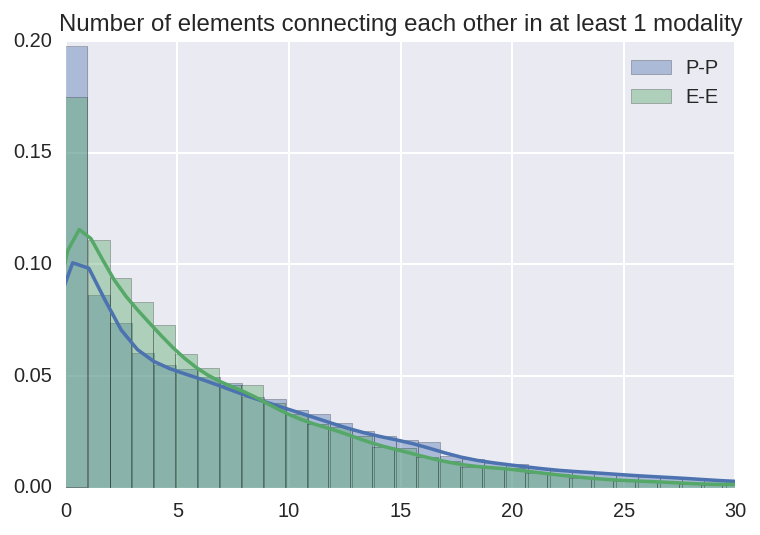

In [72]:
d = dict(ee_df[['dhs1', 'dhs2']].groupby('dhs1').count()['dhs2'])
e = dict(ee_df[['dhs1', 'dhs2']].groupby('dhs2').count()['dhs1'])

for dhs2 in e:
    if dhs2 in d: d[dhs2] += e[dhs2]
    else: d[dhs2] = e[dhs2]

d = d.values()
d.extend([0]*(type_to_num["Enhancer"] - len(contacting_enhancers)))
        
sns.distplot(a, bins=72, label="P-P")
sns.distplot(d, bins=52, label="E-E")
sns.plt.xlim([0,30])
sns.plt.legend()
sns.plt.title("Number of elements connecting each other in at least 1 modality")

20% of promoters do not contact other promoters; 17% of enhancers do not contact other enhancers. Enhancers are more likely to contact a smaller number of enhancers than promoters contacting promoters.

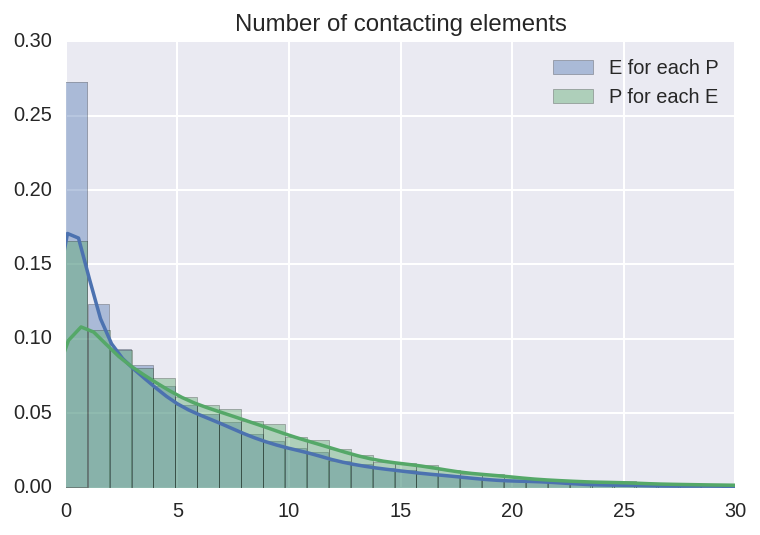

In [9]:
pe_df['dhs1'] = [x.split('___')[0] for x in pe_df.index]
pe_df['dhs2'] = [x.split('___')[1] for x in pe_df.index]
pe_df['dhs1_type'] = [dhsnum_to_type[x] for x in pe_df["dhs1"]]
pe_df['dhs2_type'] = [dhsnum_to_type[x] for x in pe_df["dhs2"]]
prom = list(pe_df[['dhs1', 'dhs2']].groupby('dhs1').count()['dhs2'])
prom.extend([0]*(type_to_num["Promoter"] - len(set(list(pe_df['dhs1'])))))
sns.distplot(prom, label="E for each P", bins=49)
enh = list(pe_df[['dhs1', 'dhs2']].groupby('dhs2').count()['dhs1'])
enh.extend([0]*(type_to_num["Enhancer"] - len(set(list(pe_df['dhs2'])))))
sns.distplot(enh, label="P for each E", bins=56)
sns.plt.legend()
sns.plt.xlim([0,30])
sns.plt.title("Number of contacting elements")

In general, promoters bind fewer enhancers than enhancers bind promoters. Thus, enhancers are a little more "general" than promoters.

Summarizing the last two plots: seems like there are "gene factories" with lots of promoters, and enhancers that bind lots of promoters.

### Differences between the 5 datasets: gene ontology + specific examples

In [143]:
pp_df1 = pp_dfnorm.copy()
pp_df1['dhs1'] = [x.split('___')[0] for x in pp_df1.index]
pp_df1['dhs2'] = [x.split('___')[1] for x in pp_df1.index]
pp_df1['dhs1_loc'] = [dhsnum_to_info[x] for x in pp_df1["dhs1"]]
pp_df1['dhs2_loc'] = [dhsnum_to_info[x] for x in pp_df1["dhs2"]]
pp_df1["m_minus_s"] = pp_df1["med1"]-pp_df1["sevensk"]
pp_df1 = pp_df1.sort("m_minus_s")

In [144]:
pp_df1.head()

,cohesin,sevensk,oct4,k27ac,med1,dhs1,dhs2,dhs1_loc,dhs2_loc,m_minus_s
13324___13330,-0.374289,0.995873,-0.310484,-0.281502,-2.131582,13324,13330,chr11 51432119 51434119,chr11 51450591 51452591,-3.127455
23417___23429,-0.729351,0.452169,-1.526970,-0.461683,-2.289661,23417,23429,chr13 23642549 23644549,chr13 23665195 23667195,-2.741829
1902___1906,-1.088027,0.451691,-0.613567,-0.916427,-2.229933,1902,1906,chr1 72289479 72291479,chr1 72301044 72303044,-2.681623
16607___16614,-1.640388,0.511574,-1.272226,-0.262851,-2.146640,16607,16614,chr11 97659463 97661463,chr11 97701498 97703498,-2.658215
95319___95330,-0.843046,0.377997,-1.710962,-0.959442,-2.225958,95319,95330,chr9 114457241 114459241,chr9 114492480 114494480,-2.603955


High 7SK:

* Nhp2-AK014724
* HistH4-HistH2
* Lasp1-B230217C12Rik
* H2-M5 with GABA-B-R

In [145]:
pp_df1.tail(20)

,cohesin,sevensk,oct4,k27ac,med1,dhs1,dhs2,dhs1_loc,dhs2_loc,m_minus_s
45960___45960,0.045662,-2.240026,0.529415,-1.036628,0.564759,45960,45960,chr19 8325809 8327809,chr19 8325809 8327809,2.804785
56157___56157,0.199241,-1.767004,0.724116,-0.052580,1.039361,56157,56157,chr3 20265193 20267193,chr3 20265193 20267193,2.806365
29945___29945,-0.066358,-2.286928,-0.088650,-0.660200,0.545883,29945,29945,chr14 94288923 94290923,chr14 94288923 94290923,2.832811
60048___60048,-0.284960,-2.251189,0.067257,-1.015650,0.627421,60048,60048,chr3 141127425 141129425,chr3 141127425 141129425,2.878609
2302___2303,0.617823,-1.862426,0.807554,0.127079,1.019665,2302,2303,chr1 83155373 83157373,chr1 83403775 83405775,2.882091
46406___46437,-0.144515,-2.306902,-0.218595,-0.619030,0.579432,46406,46437,chr19 21546135 21548135,chr19 22212696 22214696,2.886335
90823___90828,0.713363,-1.902069,0.987994,0.346389,0.993040,90823,90828,chr9 15431355 15433355,chr9 15741435 15743435,2.895109
83466___83466,0.227553,-2.131904,0.094421,-0.782716,0.770947,83466,83466,chr7 111794857 111796857,chr7 111794857 111796857,2.902851
6856___6856,-0.059434,-2.280169,0.152139,-0.521026,0.665373,6856,6856,chr10 22535005 22537005,chr10 22535005 22537005,2.945542
90501___90501,0.467011,-1.910449,0.584036,0.022260,1.074319,90501,90501,chr9 3115437 3117437,chr9 3115437 3117437,2.984768


In [ ]:
High Med1:
    
* Rab32-Grm1
* Hic2-Kpna1

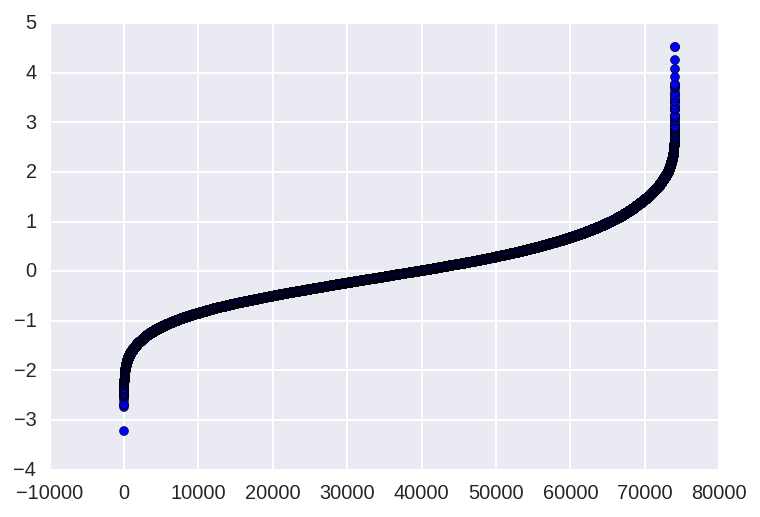

In [41]:
plt.scatter(x=range(pp_df1.shape[0]), y=pp_df1["m_minus_s"])

In [82]:
# 7SK enriched
pp_dfhead = pp_df1.head(5000)
sevensk_enr = set(pp_dfhead['dhs1']).union(set(pp_dfhead['dhs2']))
with open("interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile,\
     open("interm/nb3/sevensk_enriched_over_med1_dhs.bed", 'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    for row in reader:
        peaknum = row[3].split('__')[4].split('_')[1]
        if peaknum in sevensk_enr:
            writer.writerow(row[:3])
! wc -l interm/nb3/sevensk_enriched_over_med1_dhs.bed

3796 interm/nb3/sevensk_enriched_over_med1_dhs.bed


In [83]:
# Med1 enriched
pp_dftail = pp_df1.tail(5000)
med1_enr = set(pp_dftail['dhs1']).union(set(pp_dftail['dhs2']))
with open("interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile,\
     open("interm/nb3/med1_enriched_over_7sk_dhs.bed", 'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    for row in reader:
        peaknum = row[3].split('__')[4].split('_')[1]
        if peaknum in med1_enr:
            writer.writerow(row[:3])
! wc -l interm/nb3/med1_enriched_over_7sk_dhs.bed

4200 interm/nb3/med1_enriched_over_7sk_dhs.bed


GREAT analysis shows that the 7SK enriched promoter regions are near regions involved in nucleosome organization, polymerase opening, splicing, recombination, ribosomes, etc -- critical functions of all cells. They are also near genes that are enriched across multiple different Theiler stages. On the other hand, the Med1 enriched promoter regions are not enriched for any pathways, but many regions are near the Hox gene family (12 regions) or near KRAB boxes (143 regions) or Sfi1 (17 regions). KRAB boxes are repressors present in about a third of zinc finger proteins. Thus, regions contacted by Med1 are more likely to be involved in stage specific expression, and regions contacted by 7SK are more likely to be universally required.

Med1 over 7SK: 20160616-public-3.0.0-ZEo2ys

7SK over Med1: 

In [99]:
pe_df1 = pe_dfnorm.copy()
pe_df1['dhs1'] = [x.split('___')[0] for x in pe_df1.index]
pe_df1['dhs2'] = [x.split('___')[1] for x in pe_df1.index]
pe_df1['dhs1_loc'] = [dhsnum_to_info[x] for x in pe_df1["dhs1"]]
pe_df1['dhs2_loc'] = [dhsnum_to_info[x] for x in pe_df1["dhs2"]]
pe_df1["m_minus_s"] = pe_df1["med1"]-pe_df1["sevensk"]
pe_df1 = pe_df1.sort("m_minus_s")

In [103]:
# 7SK enriched
pe_dfhead = pe_df1.head(5000)
sevensk_enr = set(pe_dfhead['dhs1'])
with open("interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile,\
     open("interm/nb3/sevensk_enriched_over_med1_pe_dhs.bed", 'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    for row in reader:
        peaknum = row[3].split('__')[4].split('_')[1]
        if peaknum in sevensk_enr:
            writer.writerow(row[:3])
! wc -l interm/nb3/sevensk_enriched_over_med1_pe_dhs.bed

2661 interm/nb3/sevensk_enriched_over_med1_pe_dhs.bed


In [104]:
pe_df1.head()

,cohesin,sevensk,oct4,k27ac,med1,dhs1,dhs2,dhs1_loc,dhs2_loc,m_minus_s
38619___38645,0.034975,0.690178,0.284361,-0.304020,-2.277008,38619,38645,chr17 23700178 23702178,chr17 23800675 23802675,-2.967187
40182___40171,-0.465816,0.579624,-0.615748,0.506105,-2.263231,40182,40171,chr17 37181943 37183943,chr17 37130140 37132140,-2.842855
47491___28538,-1.417158,0.553514,-2.014498,-1.492757,-2.275933,47491,28538,chr19 44388116 44390116,chr14 52685191 52687191,-2.829447
39163___39164,-1.992320,0.539265,-1.708848,-2.257701,-2.276291,39163,39164,chr17 28380718 28382718,chr17 28399365 28401365,-2.815556
84444___84435,0.073547,1.052867,-0.663700,-0.572585,-1.738870,84444,84435,chr7 134396617 134398617,chr7 134367664 134369664,-2.791737


In [102]:
# Med1 enriched
pe_dftail = pe_df1.tail(5000)
med1_enr = set(pe_dftail['dhs1'])
with open("interm/nb1/160605_dhs_grodirec_sorted_pm1bp.bed", 'r') as ifile,\
     open("interm/nb3/med1_enriched_over_7sk_pe_dhs.bed", 'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    for row in reader:
        peaknum = row[3].split('__')[4].split('_')[1]
        if peaknum in med1_enr:
            writer.writerow(row[:3])
! wc -l interm/nb3/med1_enriched_over_7sk_pe_dhs.bed

2759 interm/nb3/med1_enriched_over_7sk_pe_dhs.bed


In [105]:
pe_df1.tail()

,cohesin,sevensk,oct4,k27ac,med1,dhs1,dhs2,dhs1_loc,dhs2_loc,m_minus_s
40234___48323,0.984332,-2.319963,1.067519,1.812093,1.845109,40234,48323,chr17 39984200 39986200,chr19 61274507 61276507,4.165072
36377___17699,1.191515,-1.946394,1.243297,0.226004,2.223022,36377,17699,chr16 35982393 35984393,chr11 108872166 108874166,4.169416
40234___6137,0.686468,-2.286806,0.710670,1.466515,1.939126,40234,6137,chr17 39984200 39986200,chr1 197066887 197068887,4.225932
40234___33078,-0.723381,-2.196486,-0.536223,-1.632137,2.057375,40234,33078,chr17 39984200 39986200,chr15 81819305 81821305,4.253861
36377___35053,1.349423,-2.129396,0.815958,1.045648,2.293834,36377,35053,chr16 35982393 35984393,chr16 11143195 11145195,4.423230


When we look at promoters involved in P-E contacts that are enriched for Med1 or 7SK, GREAT returns the same as above for the Med1 associated contacts (lots of KRAB box genes) but nothing for the 7SK-associated contacts. 

In [434]:
pe_df1 = pe_dfnorm.copy()
pe_df1["o_minus_c"] = pe_df1["oct4"]-pe_df1["cohesin"]
pe_df1 = pe_df1.sort("o_minus_c")

In [444]:
pe_df1.head().index

Index([u'85168___85131', u'76024___76046', u'16336___16313', u'92415___92414', u'18145___18120'], dtype='object')

In [445]:
pe_df1.tail().index

Index([u'29017___29037', u'87869___87873', u'22808___22814', u'34231___34270', u'36285___36300'], dtype='object')

In [437]:
ee_df1 = ee_dfnorm.copy()
ee_df1["o_minus_c"] = ee_df1["oct4"]-ee_df1["cohesin"]
ee_df1 = ee_df1.sort("o_minus_c")

In [446]:
ee_df1.head().index

Index([u'43705___43719', u'18319___18333', u'39008___39018', u'17620___17626', u'62259___62262'], dtype='object')

In [447]:
ee_df1.tail().index

Index([u'91783___91785', u'36397___36398', u'51234___51245', u'12773___12841', u'18186___18202'], dtype='object')

In [383]:
np.max(pp_df["oct4"]-pp_df["cohesin"])

25

## For Max: lists of promoters responsive to 7SK
He has HiC of mES before and after 7SK KD and wants to see whether 7SK-responsive promoters have different looping behavior after getting rid of 7SK

In [ ]:
mkdir forMax

mkdir: cannot create directory `forMax': File exists


In [ ]:
! head /arrayAhome/raflynn/7SK/GROseq/Flynn/metagenes/regionLists/TR_prox30_TSS_centered_list.txt

In [41]:
data = pd.read_table("/arrayAhome/raflynn/7SK/GROseq/Flynn/metagenes/regionLists/TR_prox30_TSS_centered_list.txt")
data["chg"] = data["GRO_Scr_comb_rnorm_sense"]/data["GRO_5ASO_comb_rnorm_sense"]
data_s = data.sort("chg", ascending=False)
data_s2 = data_s[data_s["GRO_5ASO_comb_rnorm_sense"] > 2]
with open("forMax/TSS_top2000_bypausingchg.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    for i in data_s2.index[:2000]:
        row = data_s2.ix[i,:]["regionName"].split('__')
        if row[-1] == '+':
            row[1] = int(row[1]) - 970
            row[2] = int(row[2]) + 700
        else:
            row[1] = int(row[1]) - 700
            row[2] = int(row[2]) + 970
        writer.writerow(row)
data_s = data.sort("chg", ascending=True)
data_s3 = data_s[data_s["GRO_Scr_comb_rnorm_sense"] > 2]
with open("forMax/TSS_bottom2000_bypausingchg.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    for i in data_s3.index[:2000]:
        row = data_s3.ix[i,:]["regionName"].split('__')
        if row[-1] == '+':
            row[1] = int(row[1]) - 970
            row[2] = int(row[2]) + 700
        else:
            row[1] = int(row[1]) - 700
            row[2] = int(row[2]) + 970
        writer.writerow(row)
! head forMax/TSS_top2000_bypausingchg.bed

In [2]:
! head /arrayAhome/raflynn/7SK/GROseq/Flynn/metagenes/regionLists/TSS_centered_list.txt

In [3]:
! head /arrayAhome/raflynn/7SK/ChIRPseq/metagenes/regionLists/TSS_centered_list.txt

In [43]:
data = pd.read_table("/arrayAhome/raflynn/7SK/ChIRPseq/metagenes/regionLists/TSS_centered_list.txt")
data_s = data.sort("7SK_mES_WT", ascending=False)
with open("forMax/TSS_top2000_by7skbound.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    for i in data_s.index[:2000]:
        writer.writerow(data_s.ix[i,:]["regionName"].split('__'))
data_s = data.sort("7SK_mES_WT", ascending=True)
with open("forMax/TSS_bottom2000_by7skbound.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    for i in data_s.index[:2000]:
        writer.writerow(data_s.ix[i,:]["regionName"].split('__'))
! head forMax/TSS_top2000_by7skbound.bed
with open("forMax/TSS_all.bed", 'w') as ofile:
    writer = csv.writer(ofile, 'textdialect')
    for i in range(data_s.shape[0]):
        writer.writerow(data_s.ix[i,:]["regionName"].split('__'))
! head forMax/TSS_top2000_by7skbound.bed

chr19	5801671	5803671	Malat1	141	-
chr11	62415952	62417952	2410006H16Rik	787	+
chr2	25145430	25147430	Grin1os	121	+
chr13	23662257	23664257	Hist1h2bg	229	+
chr1	162964981	162966981	Gas5	1057	+
chr2	166887722	166889722	1500012F01Rik	533	+
chr15	79912350	79914350	Rpl3	706	-
chr7	3216837	3218837	D7Ertd143e	0	+
chr13	23775071	23777071	Hist1h2bc	243	+
chr13	23662028	23664028	Hist1h2ae	229	-
chr19	5801671	5803671	Malat1	141	-
chr11	62415952	62417952	2410006H16Rik	787	+
chr2	25145430	25147430	Grin1os	121	+
chr13	23662257	23664257	Hist1h2bg	229	+
chr1	162964981	162966981	Gas5	1057	+
chr2	166887722	166889722	1500012F01Rik	533	+
chr15	79912350	79914350	Rpl3	706	-
chr7	3216837	3218837	D7Ertd143e	0	+
chr13	23775071	23777071	Hist1h2bc	243	+
chr13	23662028	23664028	Hist1h2ae	229	-
